<a href="https://colab.research.google.com/github/Aravindh4404/FYPSeagullClassification01/blob/main/KarpathytryPytorch1710_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive


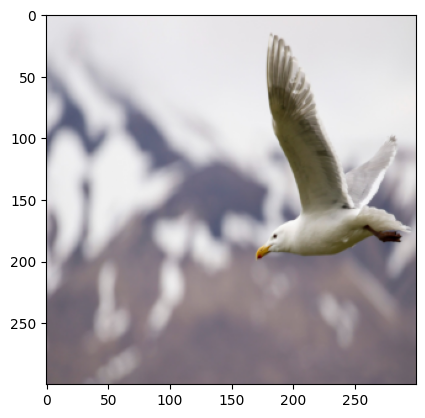

Epoch [1/100], Loss: 0.707167
Epoch [2/100], Loss: 5.203418
Epoch [3/100], Loss: 4.373146
Epoch [4/100], Loss: 6.239395
Epoch [5/100], Loss: 4.679414
Epoch [6/100], Loss: 1.188950
Epoch [7/100], Loss: 1.881732
Epoch [8/100], Loss: 3.034787
Epoch [9/100], Loss: 1.811484
Epoch [10/100], Loss: 0.015412
Epoch [11/100], Loss: 0.483223
Epoch [12/100], Loss: 0.939842
Epoch [13/100], Loss: 1.027743
Epoch [14/100], Loss: 0.791632
Epoch [15/100], Loss: 0.343191
Epoch [16/100], Loss: 0.012389
Epoch [17/100], Loss: 0.005732
Model overfitted on one batch.
Epoch [1/20], Loss: 4.198152
Validation Loss: 4.360377, Accuracy: 43.14%
Best model saved with accuracy: 43.1373% at /content/drive/My Drive/FYP/ModelCheckpoints/best_model.pth
Epoch [2/20], Loss: 1.040337
Validation Loss: 0.780918, Accuracy: 58.82%
Best model saved with accuracy: 58.8235% at /content/drive/My Drive/FYP/ModelCheckpoints/best_model.pth
Epoch [3/20], Loss: 0.440370
Validation Loss: 0.570729, Accuracy: 76.47%
Best model saved with ac

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Mount Google Drive to save and load the model
from google.colab import drive
drive.mount('/content/drive')

# Define the folder to save model checkpoints
checkpoint_folder = '/content/drive/My Drive/FYP/ModelCheckpoints/'
os.makedirs(checkpoint_folder, exist_ok=True)

# Simple data transformations (no augmentation for now)
transform_train = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),  # Convert to tensor
])

transform_val_test = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])

# Data preparation: Training, Validation, and Test sets
data_path = '/content/drive/My Drive/FYP/Dataset/Original_Adult_In-flight/train'
test_data_path = '/content/drive/My Drive/FYP/Dataset/Original_Adult_In-flight/test'

# Load datasets
train_dataset = datasets.ImageFolder(data_path, transform=transform_train)
test_dataset = datasets.ImageFolder(test_data_path, transform=transform_val_test)

# Split the dataset into 80% training and 20% validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define a TinyCNN model to simplify initial testing
class TinyCNN(nn.Module):
    def __init__(self):
        super(TinyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # A very simple CNN layer
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 150 * 150, 2)  # Flattened after pooling

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, 16 * 150 * 150)  # Flatten the tensor
        x = self.fc1(x)
        return x

# Initialize the TinyCNN model
model = TinyCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to save the best model
def save_best_model(model, folder_path, best_val_acc):
    model_save_path = os.path.join(folder_path, "best_model.pth")
    torch.save(model.state_dict(), model_save_path)
    print(f"Best model saved with accuracy: {best_val_acc:.4f}% at {model_save_path}")

# Function to visualize inputs before they enter the model
def visualize_inputs_before_model(train_loader):
    inputs, _ = next(iter(train_loader))
    img = inputs[0].numpy().transpose((1, 2, 0))  # Convert tensor to image format
    plt.imshow(img)
    plt.show()

# Function to test overfitting on one batch of data
def overfit_one_batch(model, train_loader, criterion, optimizer, epochs=100):
    model.train()
    inputs, labels = next(iter(train_loader))  # Take one batch

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")

        if loss.item() < 0.01:  # Stop when loss is sufficiently small
            print("Model overfitted on one batch.")
            break

# Training loop with validation accuracy and precision printing
def train(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    model.train()
    best_val_acc = 0.0  # Initialize the best validation accuracy

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Print the loss per epoch with more precision
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.6f}")

        # Validate the model and check accuracy
        val_acc = validate(model, val_loader, criterion)

        # Save the model if validation accuracy improves
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_best_model(model, checkpoint_folder, best_val_acc)

# Validation loop returning accuracy
def validate(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss/len(loader):.6f}, Accuracy: {accuracy:.2f}%')
    return accuracy  # Return accuracy to track the best model

# Test function to evaluate on the test set
def test(model, loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Loss: {test_loss/len(loader):.6f}, Test Accuracy: {accuracy:.2f}%')

# Run the full code sequence

# Step 1: Visualize inputs before training
visualize_inputs_before_model(train_loader)

# Step 2: Overfit on one batch of data to verify model correctness
overfit_one_batch(model, train_loader, criterion, optimizer, epochs=100)

# Step 3: Train the model on the full dataset
train(model, train_loader, val_loader, criterion, optimizer, epochs=20)

# Step 4: Evaluate the model on the test set
test(model, test_loader, criterion)


1. Overfitting on One Batch

You ran the model on one batch of data to verify that the model can overfit a small sample of the data. The output for the overfitting phase shows:

less

Epoch [1/100], Loss: 0.707167
...
Epoch [17/100], Loss: 0.005732
Model overfitted on one batch.

This indicates that the model successfully overfitted on the single batch. It managed to get the loss down to a very small value, confirming that the model is capable of learning the data when there are only a few samples involved. This means the model and the training code are functioning correctly on a basic level, as it can fully memorize a small batch of data.
2. Full Training and Validation

The training for the full dataset happens over 20 epochs, and here are some key points:

    Training Loss: The training loss starts at 4.198152 and reduces steadily to 0.010455 by the 20th epoch. This indicates that the model is learning the training data well and can predict the training data accurately.

    Validation Loss and Accuracy:
        In the first epoch, the validation loss is 4.360377 and the accuracy is 43.14%, which is expected at the beginning since the model has just started training.
        By the 6th epoch, the validation loss drops to 0.495277 and the accuracy improves to 80.39%.
        However, after that, the validation accuracy fluctuates slightly, hovering around 76%-78%. The lowest validation loss was 0.495277, and the highest validation accuracy was 80.39%.

This behavior suggests that the model learns well initially but eventually plateaus and stops improving significantly after a certain point. The model achieves a reasonable validation accuracy of 80.39%, indicating that it's generalizing to the validation set to some degree.
3. Low Test Accuracy

After completing training, the model is evaluated on the test dataset, which is a completely unseen set of images. Here’s the output:

yaml

Test Loss: 1.887988, Test Accuracy: 54.90%

## This means that the model achieved 54.90% accuracy on the test set, which is significantly lower than the validation accuracy of 80.39%.